<a href="https://colab.research.google.com/github/rtnaka/ai-quest2021_assessment/blob/main/PBL01_sample_code_%E6%94%B9%E5%A4%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import library

In [1]:
!pip install japanize-matplotlib
!pip install category_encoders

In [2]:
from itertools import product
from datetime import datetime

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import japanize_matplotlib 

import category_encoders as ce

from lightgbm import LGBMRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# read data

In [3]:
# Google DriveをColabにマウント
from google.colab import drive
drive.mount('/content/drive')

#　filepath
basepath = '/content/drive/MyDrive/AI Quest2021/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
sales = pd.read_csv(basepath+'sales_history.csv',parse_dates=["日付"])
cats = pd.read_csv(basepath+'item_categories.csv')
cat_names = pd.read_csv(basepath+'category_names.csv')
test = pd.read_csv(basepath+'test.csv',index_col=0)
sub = pd.read_csv(basepath+'sample_submission.csv', header=None)

In [5]:
#最大表示行数指定
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)

# Preprocess

### merge table

In [6]:
#category_names 　→　大カテゴリ/小カテゴリに分割
split_catname = cat_names["商品カテゴリ名"].str.split("-",expand=True)
cat_names = pd.concat([cat_names,split_catname],axis=1)
cat_names.drop("商品カテゴリ名",axis=1,inplace=True)
cat_names.rename(columns={0: '商品大カテゴリ', 1: '商品小カテゴリ'},inplace=True)
cat_names.head()

,商品カテゴリID,商品大カテゴリ,商品小カテゴリ
0,100,映画,DVD
1,110,PCゲーム,通常版
2,120,音楽,その他
3,130,ゲーム,ゲーム機C
4,140,映画,ブルーレイ


In [7]:
#「sales_history.csv」、「item_category.csv」、「category_names.csv」の3つのテーブルを統合
sales = pd.merge(sales, cats, on='商品ID', how='left')
sales = pd.merge(sales, cat_names, on='商品カテゴリID', how='left')
sales.head()

,日付,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,商品大カテゴリ,商品小カテゴリ
0,2018-01-01,9,1000001,420,1.0,100,映画,DVD
1,2018-01-01,6,1000001,420,1.0,100,映画,DVD
2,2018-01-01,10,1000001,420,1.0,100,映画,DVD
3,2018-01-01,0,1000017,250,1.0,100,映画,DVD
4,2018-01-01,1,1000017,250,1.0,100,映画,DVD


### add columns

In [8]:
# 日付列から年と月を抽出し、新たな列とする
sales['年'] = sales['日付'].dt.year
sales['月'] = sales['日付'].dt.month
sales['四半期'] = sales['日付'].dt.quarter

In [9]:
# 「年」と「月」の全組み合わせを作成する
gp_time = sales.groupby(['年','月','四半期']).count().reset_index()[['年', '月','四半期']]
# カラム名「月ブロック」として、通し番号をつける
gp_time['月ブロック'] = list(range(len(gp_time)))

# 2019年12月(月ブロック: 23)のレコードを追加する
gp_time = gp_time.append({
    '月ブロック': 23,
    '年': 2019,
    '月': 12,
    '四半期':4
}, ignore_index=True)

In [10]:
# 「月ブロック」カラムをsalesに統合する
sales = pd.merge(sales, gp_time, on=['年', '月','四半期'], how='left')

In [11]:
#売上金額を追加
sales["売上金額"] = sales.商品価格 * sales.売上個数

In [12]:
#商品価格をbiningし、価格帯として列作成
price_bin = pd.DataFrame(pd.cut(sales.商品価格, [0, 300,500,750,1000,2000,3000,10000],labels=False))
price_bin.columns = ["価格帯"]
sales = pd.concat([sales,price_bin],axis=1)

### extract 

In [13]:
# #需要予測対象の170商品の抜き出し
product_id = test["商品ID"].unique()
sales = sales[sales["商品ID"].isin(product_id)]

# EDA

In [14]:
# 2018年に販売実績のある商品数
items_2018 = sales[sales["日付"] < datetime(2019, 1, 1)]["商品ID"].unique()
# 2018年10月以前に販売実績のある商品数
items_2018_before10 = sales[sales["日付"] < datetime(2018, 9, 30)]["商品ID"].unique()
# 2019年に販売実績のある商品数
items_2019 = sales[sales["日付"] > datetime(2018, 12, 31)]["商品ID"].unique()
# 2019年4月以降に販売実績のある商品数
items_2019_04 = sales[sales["日付"] > datetime(2019, 3, 31)]["商品ID"].unique()
# 2019年7月以降に販売実績のある商品数
items_2019_07 = sales[sales["日付"] > datetime(2019, 6, 30)]["商品ID"].unique()
# 2019年10月以降に販売実績のある商品数
items_2019_10 = sales[sales["日付"] > datetime(2019, 9, 30)]["商品ID"].unique()
#2018年１２月に販売実績のあった商品数
items_201812 = sales[(sales["日付"] > datetime(2018, 11, 30))&(sales["日付"] < datetime(2019, 1, 1))]["商品ID"].unique()
#2019年10月に販売実績のない商品ID
items_201910_notSales =  np.setdiff1d(items_2019_07, items_2019_10)
#2019年から販売開始された　or ２０１８年は実績がなかった商品
items_2019only = np.setdiff1d(items_2019, items_2018)
items_201810start = np.setdiff1d(items_2018, items_2018_before10)

print("2018年販売実績あり：",len(items_2018))
print("2018年9月までに販売実績あり：",len(items_2018_before10))
print("2019年販売実績あり：",len(items_2019))
print("2019年4月以降販売実績あり：",len(items_2019_04))
print("2019年7月以降販売実績あり：",len(items_2019_07))
print("2019年10月以降販売実績あり：",len(items_2019_10))
print("2018年12月に販売実績あり：",len(items_201812))
print("2019年10月に販売実績のない商品ID",items_201910_notSales)
print("２０１８年販売実績無し",items_2019only)
print("２０１８年10月~12月で販売開始",items_201810start)

2018年販売実績あり： 150
2018年9月までに販売実績あり： 131
2019年販売実績あり： 170
2019年4月以降販売実績あり： 170
2019年7月以降販売実績あり： 170
2019年10月以降販売実績あり： 168
2018年12月に販売実績あり： 150
2019年10月に販売実績のない商品ID [1700013 3000001]
２０１８年販売実績無し [1002291 1002377 1002503 1002582 1201262 1201269 1400898 1600052 1600054
 1800179 2000162 2100152 2400088 2500229 2500230 2800090 2800101 2800103
 2900075 3200026]
２０１８年10月~12月で販売開始 [1000011 1100002 1200036 1200037 1200038 1200039 1200040 1500001 1700019
 1800003 1800004 1900002 2200001 2300003 2300004 2400012 2400013 2400014
 2500007]


In [15]:
pd.options.display.float_format = '{:.2f}'.format
sales.describe(percentiles=[0.9,0.99,0.999,0.9999])

,店舗ID,商品ID,商品価格,売上個数,商品カテゴリID,年,月,四半期,月ブロック,売上金額,価格帯
count,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00,48221.00
mean,8.07,1815224.63,1048.98,1.05,181.51,2018.51,6.28,2.43,11.35,1101.62,2.62
std,4.96,674604.62,958.35,0.38,67.47,0.50,3.45,1.12,6.09,1171.45,1.73
min,0.00,1000001.00,60.00,-2.00,100.00,2018.00,1.00,1.00,0.00,-3400.00,0.00
50%,8.00,1700001.00,590.00,1.00,170.00,2019.00,6.00,2.00,12.00,590.00,2.00
90%,15.00,2800001.00,2450.00,1.00,280.00,2019.00,11.00,4.00,19.00,2550.00,5.00
99%,17.00,3400003.00,5100.00,2.00,340.00,2019.00,12.00,4.00,21.00,5100.00,6.00
99.9%,17.00,3500001.00,6460.00,5.00,350.00,2019.00,12.00,4.00,21.00,10200.00,6.00
99.99%,17.00,3500001.00,6460.00,14.00,350.00,2019.00,12.00,4.00,21.00,17115.60,6.00
max,17.00,3500001.00,6460.00,24.00,350.00,2019.00,12.00,4.00,21.00,71400.00,6.00


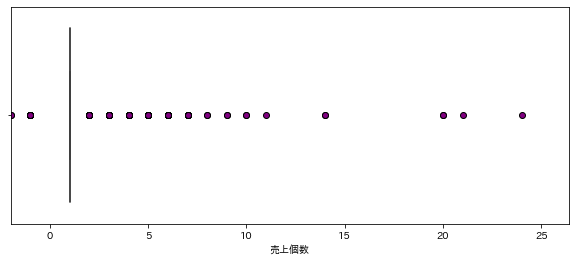

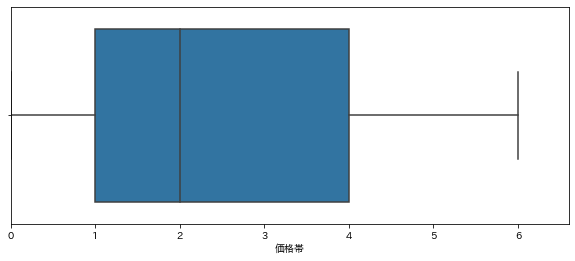

In [16]:
plt.figure(figsize=(10,4))
plt.xlim(sales.売上個数.min(), sales.売上個数.max()*1.1)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales.売上個数, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(sales.価格帯.min(), sales.価格帯.max()*1.1)
sns.boxplot(x=sales.価格帯, flierprops=flierprops)

# Create Dataset

### テーブル変換

In [17]:
def crate_monthly_table (df_sales):
  gp_month = df_sales.groupby(['月ブロック', '商品ID', '店舗ID']).agg({'売上個数': np.sum}).reset_index()
  yyyymm =  np.sort(df_sales.月ブロック.unique())
  all_combination = []
  columns = ['月ブロック', '商品ID', '店舗ID']

  #商品ID×店舗IDの直積
  for i in yyyymm:
    all_combination.append(list(product([i], df_sales.商品ID.unique(), df_sales.店舗ID.unique())))
  
  all_combination = pd.DataFrame(np.vstack(np.array(all_combination)), columns=columns)
  all_combination.sort_values(columns, inplace=True)

  # all_combinationにsalesテーブルを統合
  all_train = pd.merge(all_combination, gp_month, on=['月ブロック', '商品ID', '店舗ID'], how='left')

  return all_train

### train/testのデータ結合

In [18]:
def merge_train_test (df_train,df_test):
  df_test['月ブロック'] = 23
  dataset = pd.concat([df_train, df_test])

  return dataset

# Feature Engneering

### 商品カテゴリ・時間情報の結合

In [19]:
def merge_category_columns(dataset,cats,cat_names,gp_time): 
  dataset = pd.merge(dataset, cats, on='商品ID', how='left')
  dataset = pd.merge(dataset, cat_names, on='商品カテゴリID', how='left')
  dataset = pd.merge(dataset, gp_time, on='月ブロック', how='left')

  return dataset

### 集約特徴量の作成

In [20]:
def merge_agg_table(dataset,sales):
  #売上個数がマイナス＝返品と捉え、商品ID毎の返品数のテーブルを作成
  returns = pd.DataFrame(sales[sales.売上個数 < 0].商品カテゴリID.value_counts()).reset_index()
  returns.columns = ["商品カテゴリID","返品回数"]

  #売上レコードが始めて現れた月　売上レコードなしの組み合わせは-1
  sales_start_month = sales.groupby(["店舗ID","商品ID"])["月ブロック"].agg(販売開始月ブロック = "min").unstack(fill_value=-1).stack()
  sales_start_month = pd.DataFrame(sales_start_month).reset_index()

  #売上レコードが始めて現れた月　商品毎
  sales_start_month_p = sales.groupby(["商品ID"])["月ブロック"].agg(販売開始月ブロック_pid = "min").reset_index()
  sales_start_month_p.head()

  #商品ID毎に定価（価格の最大値、セール価格（min)、平均と中央を算出
  #pid = product ID
  agg_productID_price = sales.groupby(['商品ID'])["商品価格"].agg(定価_pid="max",セール価格_pid="min",平均価格_pid="mean",中央値価格_pid="median").reset_index()
  price_bin = pd.DataFrame(pd.cut(agg_productID_price.定価_pid, [0, 300,500,750,1000,2000,3000,10000],labels=False))
  price_bin.columns = ["価格帯"]
  agg_productID_price = pd.concat([agg_productID_price,price_bin],axis=1)

  #商品カテゴリID毎に定価（価格の最大値、セール価格（min)、平均と中央を算出
  #cid = categoryID
  agg_catID_price = sales.groupby(['商品カテゴリID'])["商品価格"].agg(最大価格_cid="max",最小価格_cid="min",平均価格_cid="mean",中央値価格_cid="median").reset_index()

  #商品大カテゴリID毎に定価（価格の最大値、セール価格（min)、平均と中央を算出
  # lc = Large Category
  agg_LargeCat_price = sales.groupby(['商品大カテゴリ'])["商品価格"].agg(最大価格_lc="max",最小価格_lc="min",平均価格_lc="mean",中央値価格_lc="median").reset_index()


  dataset = pd.merge(dataset, returns, on='商品カテゴリID', how='left')
  dataset["返品回数"].fillna(0,inplace=True)

  dataset = pd.merge(dataset, sales_start_month, on=["店舗ID","商品ID"], how='left')
  dataset = pd.merge(dataset, sales_start_month_p, on='商品ID', how='left')
  dataset = pd.merge(dataset, agg_productID_price, on='商品ID', how='left')
  dataset = pd.merge(dataset, agg_catID_price, on='商品カテゴリID', how='left')
  dataset = pd.merge(dataset, agg_LargeCat_price, on='商品大カテゴリ', how='left')

  return dataset

### 特徴量追加

In [21]:
def add_columns(dataset):
  #月ごとの日数列を作成
  days_of_month = pd.DataFrame({'月': range(1,13),'日数': [31,28,31,30,31,30,31,31,30,31,30,31]})
  dataset = pd.merge(dataset, days_of_month, on='月', how='left')

  #商品が店舗で販売開始されてからの経過月数列を作成
  dataset["販売開始経過月ブロック_pid"] = (dataset["月ブロック"] - dataset["販売開始月ブロック_pid"]).astype("int8")
  dataset["販売開始経過月ブロック"] = (dataset["月ブロック"] - dataset["販売開始月ブロック"]).astype("int8")

  #特定キーワードを含むか判定する列を作成
  col = "商品小カテゴリ"
  new_col = "ゲーム"
  dataset[new_col] = dataset[col].str.contains(new_col).astype("int8")

  new_col = "記念品"
  dataset[new_col] = dataset[col].str.contains(new_col).astype("int8")

  #割引率を表す列を作成
  dataset["割引率"] = (dataset["セール価格_pid"]/dataset["定価_pid"]).astype("float64")
  dataset["割引額"] = (dataset["定価_pid"] - dataset["セール価格_pid"]).astype("int32")

  #
  dataset["大カテゴリ-価格帯"] = dataset["商品大カテゴリ"] +dataset["価格帯"].astype(str)

  return dataset


### 型変換

In [22]:
def translate_dataType(dataset):
  cols_int8 = ["月ブロック","店舗ID","月","四半期","返品回数","販売開始月ブロック","販売開始月ブロック_pid","価格帯","日数"]
  dataset[cols_int8] = dataset[cols_int8].astype("int8")

  cols_int32 = ["定価_pid","セール価格_pid","中央値価格_pid","最大価格_cid","最小価格_cid","中央値価格_cid","最大価格_lc","最小価格_lc","中央値価格_lc"]
  dataset[cols_int32] = dataset[cols_int32].astype("int32")

  return dataset

### ラグ特徴量の作成

In [23]:
def create_lag_feature(df_sales,dataset,agg_name,agg_cols):
  gp_month_count = df_sales.groupby(agg_cols).agg({'売上個数': "count"}).reset_index()
  gp_month_sum = df_sales.groupby(agg_cols).agg({'売上個数': np.sum}).reset_index()
  gp_month_max = df_sales.groupby(agg_cols).agg({'売上個数': np.max}).reset_index()

  gp_month_list = [gp_month_count,gp_month_sum,gp_month_max]
  gp_month_names = ["count","sum","max"]


  for gp_month,gp_month_name in zip(gp_month_list,gp_month_names):
    for i in [2,12]:
      lag = gp_month.copy()   
      lag['月ブロック'] = lag['月ブロック'] + i

      change_col_name = str(i)+'m_('+agg_name+')売上数_'+gp_month_name
      lag = lag.rename(columns={'売上個数': change_col_name})

      dataset = pd.merge(dataset, lag, on= agg_cols, how='left', left_index=True)
      dataset[change_col_name].fillna(0,inplace=True)
  return dataset

### 移動統計量の作成

In [24]:
def create_rolling_feature(dataset,cols_target,col_name_prefix): 

  cols_list = [cols_target]
  agg_num = ["12-14"]
  

  for num,cols in zip(agg_num,cols_list): 
    col_name = '売上個数({})_agg{}m_sum'.format( col_name_prefix, num )
    dataset[col_name] = dataset[cols].sum(axis=1)

    col_name = '売上個数({})_agg{}m_max'.format( col_name_prefix, num )
    dataset[col_name] = dataset[cols].max(axis=1)

    col_name = '売上個数({})_agg{}m_mean'.format(col_name_prefix,  num )
    dataset[col_name] = dataset[cols].mean(axis=1)

  return dataset

### エンコーディング

In [25]:
def encording (dataset):

  month= dataset.groupby("月ブロック").agg({"売上個数":np.sum}).reset_index()
  month["月ブロック"] = month["月ブロック"]+1
  month.rename(columns={"月ブロック":"月","売上個数":"月_変換"},inplace=True)
  dataset = pd.merge(dataset, month, on="月", how='left')
  dataset.drop("月",axis=1,inplace=True)


  col = "商品ID"
  df = dataset.copy()
  df["売上金額"] = df["売上個数"] * df["平均価格_pid"]
  df_agg = df.groupby(col).agg({"売上金額":np.sum}).reset_index()
  df_agg.rename(columns={'売上金額': "変換"+col},inplace=True)
  df_agg.nunique()

  dataset = pd.merge(dataset, df_agg, on=col, how='left')
  dataset.drop(col,axis=1,inplace=True)

  cols = ["店舗ID","商品カテゴリID","商品大カテゴリ","商品小カテゴリ","大カテゴリ-価格帯"]
  for col in cols:
    target = "売上個数"

    df_agg = dataset.groupby(col).agg({target:np.sum}).reset_index()
    df_agg.rename(columns={target: "変換"+col},inplace=True)

    dataset = pd.merge(dataset, df_agg, on=col, how='left')
    dataset.drop(col,axis=1,inplace=True)

  

  return dataset

# Modeling

### 検定無し

In [26]:
def train_test_split(dataset):
  train_dataset = dataset[(dataset['月ブロック'] >= 12) & (dataset['月ブロック'] < 22)]
  test_dataset = dataset[dataset['月ブロック'] == 23]

  # train_dataset = train_dataset.drop("月ブロック",axis=1)
  # test_dataset = test_dataset.drop("月ブロック",axis=1)

  X_train = train_dataset.drop('売上個数', axis=1)
  y_train = train_dataset['売上個数']
  X_test = test_dataset.drop(['売上個数'], axis=1)

  return X_train,y_train,X_test

In [27]:
def modeling(X_train,y_train,X_test,seed):
  clf = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
                                importance_type='split', learning_rate=0.05, max_depth=-1,
                                min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=9999, n_jobs=-1, num_leaves=31, objective='regression',
                                random_state=seed, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000, subsample_freq=0,)
  clf.fit(X_train, y_train,)

  feature_importance = pd.DataFrame(
                                    clf.booster_.feature_importance(importance_type='gain'), 
                                    index = X_train.columns, columns=['importance']).sort_values(['importance'], 
                                    ascending=False
                                    )

  y_pred = clf.predict(X_test)

  return y_pred,feature_importance

# 関数実行

In [28]:
train = crate_monthly_table(sales)
dataset = merge_train_test (train,test)
dataset = merge_category_columns(dataset,cats,cat_names,gp_time)
dataset = merge_agg_table(dataset,sales)

#未販売に該当する行の削除、その他売上個数列のNaNを0埋め
dataset["未販売"] = (dataset["月ブロック"] <  dataset["販売開始月ブロック_pid"]).astype(int)
dataset = dataset.loc[dataset.未販売 == 0,]
dataset["売上個数"].fillna(0,inplace=True)
dataset.drop("未販売",axis=1,inplace=True)

#特徴量追加
dataset = add_columns(dataset)

#データ型変換
dataset.drop("年",axis=1,inplace=True)
dataset = translate_dataType(dataset)

#lag特徴量追加
agg_names = ["個別","商品別"]
agg_cols_list = [['月ブロック', '商品ID','店舗ID'],['月ブロック', '商品ID']]

for agg_name,agg_cols in zip(agg_names,agg_cols_list):
  dataset = create_lag_feature(sales,dataset,agg_name,agg_cols)

#移動統計量追加
# cols = list(dataset.columns)
# cols_combi = [col for col in cols if '(個別)売上数_sum' in col]
# cols_product = [col for col in cols if '(商品別)売上数_sum' in col]
# cols_catID = [col for col in cols if '(カテゴリID別)売上数_sum' in col]
# cols_catL = [col for col in cols if '(大カテゴリ別)売上数_sum' in col]
# cols_priceBin = [col for col in cols if '(価格帯別)売上数_sum' in col]

# cols_target_list = [cols_combi,cols_product,cols_catID,cols_catL,cols_priceBin]
# col_name_prefix_list = ["個別","商品別","カテゴリID別","大カテゴリ別","価格帯別"]

# for cols_target ,col_name_prefix in zip(cols_target_list,col_name_prefix_list):
#   dataset = create_rolling_feature(dataset , cols_target, col_name_prefix)

#エンコーディング
dataset = encording(dataset)

#モデリング
seeds = [71,99,200]
y_pred = np.zeros(len(test))

for seed in seeds:
  X_train,y_train,X_test = train_test_split(dataset)
  y_pred_seed,feature_importance = modeling(X_train,y_train,X_test,seed)

  # figure = plt.figure(figsize=(10, 50))
  # sns.set(font="IPAexGothic")
  # sns.barplot(x="importance", y=feature_importance.index, data=feature_importance)

  y_pred += y_pred_seed

y_pred = y_pred/len(seeds)
test['y'] = y_pred
test.loc[test['y'] < 0 ,'y'] = 0
  

In [29]:
test.head()

,商品ID,店舗ID,月ブロック,y
index,,,,
0,1000001,0,23,0.09
1,1000001,1,23,0.40
2,1000001,2,23,2.00
3,1000001,3,23,3.27
4,1000001,4,23,9.16


In [30]:
test.describe()

,商品ID,店舗ID,月ブロック,y
count,3060.00,3060.00,3060.00,3060.00
mean,1868329.94,8.50,23.00,1.29
std,684766.56,5.19,0.00,3.18
min,1000001.00,0.00,23.00,0.00
25%,1200026.00,4.00,23.00,0.27
50%,1700013.50,8.50,23.00,0.66
75%,2400088.00,13.00,23.00,1.28
max,3500001.00,17.00,23.00,56.36


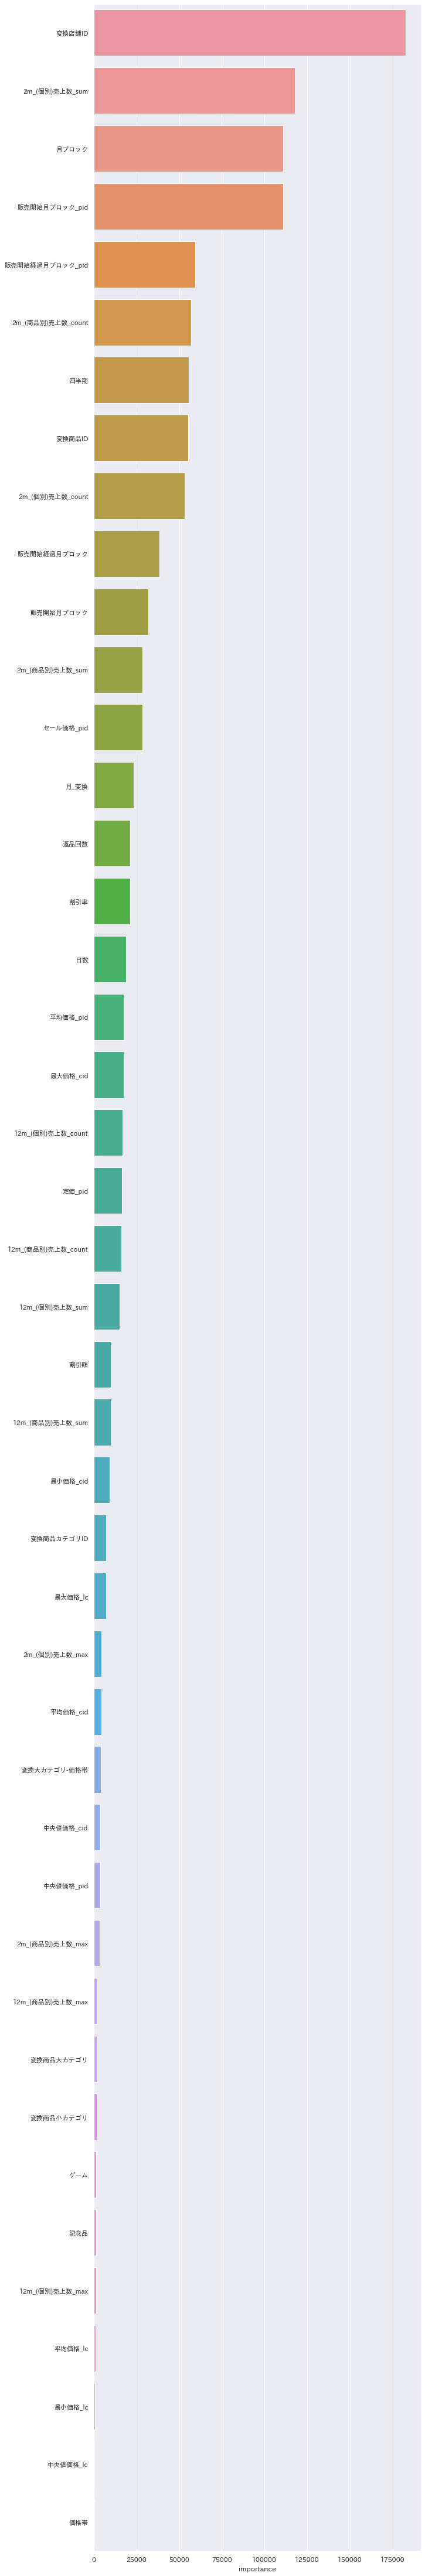

In [31]:
figure = plt.figure(figsize=(10, 80))
sns.set(font="IPAexGothic")
sns.barplot(x="importance", y=feature_importance.index, data=feature_importance)

# Submission

In [32]:
# sample_submissionの右側のカラムに予測値を代入する。
sub.iloc[:, -1] = test['y']
sub

,0,1
0,0,0.09
1,1,0.40
2,2,2.00
3,3,3.27
4,4,9.16
...,...,...
3055,3055,1.94
3056,3056,0.05
3057,3057,0.00
3058,3058,0.11


In [33]:
# 予測ファイルの生成
sub.to_csv('my_submission_20211006_simpleモデル.csv', index=False, header=False)